# About

This notebook is a basic example for looking at individual events, creating a solution and submitting it. It walks through some of the library function for accessing the data and writing a submission file. This example uses the Hough transform to solve the tracking problem.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

In [ ]:
path_to_train = "../input/train_1"

# Working on a single event

In [ ]:
event_prefix = "event000001000"

## Read and look

In [ ]:
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

In [ ]:
hits.head()

## Identify tracks

### Hough Transform

Consider a track pattern recognition method using the Hough Transform in polar system. In this system a circular track can be parametrized as follow:

$$
r = 2r_{0}Cos(\phi - \theta)
$$

where:
* $r$ and $\phi$ : are coordinates of a hit in the polar system.
* $r_{0}$ and $\theta$ : are coordinates of a center of a circular track in the polar system.

A linear track corresponds to the $r_{0} = \infty$.

Transformation of cartesian coordinates of a hit to polar coordinates defined as:

$$
\phi = arctan(\frac{y}{x})
$$
$$
r = \sqrt{x^{2} + y^{2}}
$$


The Hough Transform converts a hit in $(r, \phi)$ space to a curve in $(\frac{1}{r_{0}}, \theta)$ space of the track parameters as follow:

$$
\frac{1}{r_{0}} = \frac{2Cos(\phi - \theta)}{r}
$$

A linear track in this space represents as $(0, \theta)$ point.



however, there are 3 dimensions: x, y, z. Thus, the track pattern recognition will be performed in cylindrical coordinate systems: $\phi$, r, z. For the simplicity (but you can create your own parameter) we suppose that for 3D tracks:

$$
\gamma=\frac{z}{r}=const
$$

which is true for high-PT tracks.

This section demonstrates the track pattern recognition method using Hough Transfrom described above and histogramming technique. In this technique each 'hot' bin represents one recognized track as it is shown in the figure:

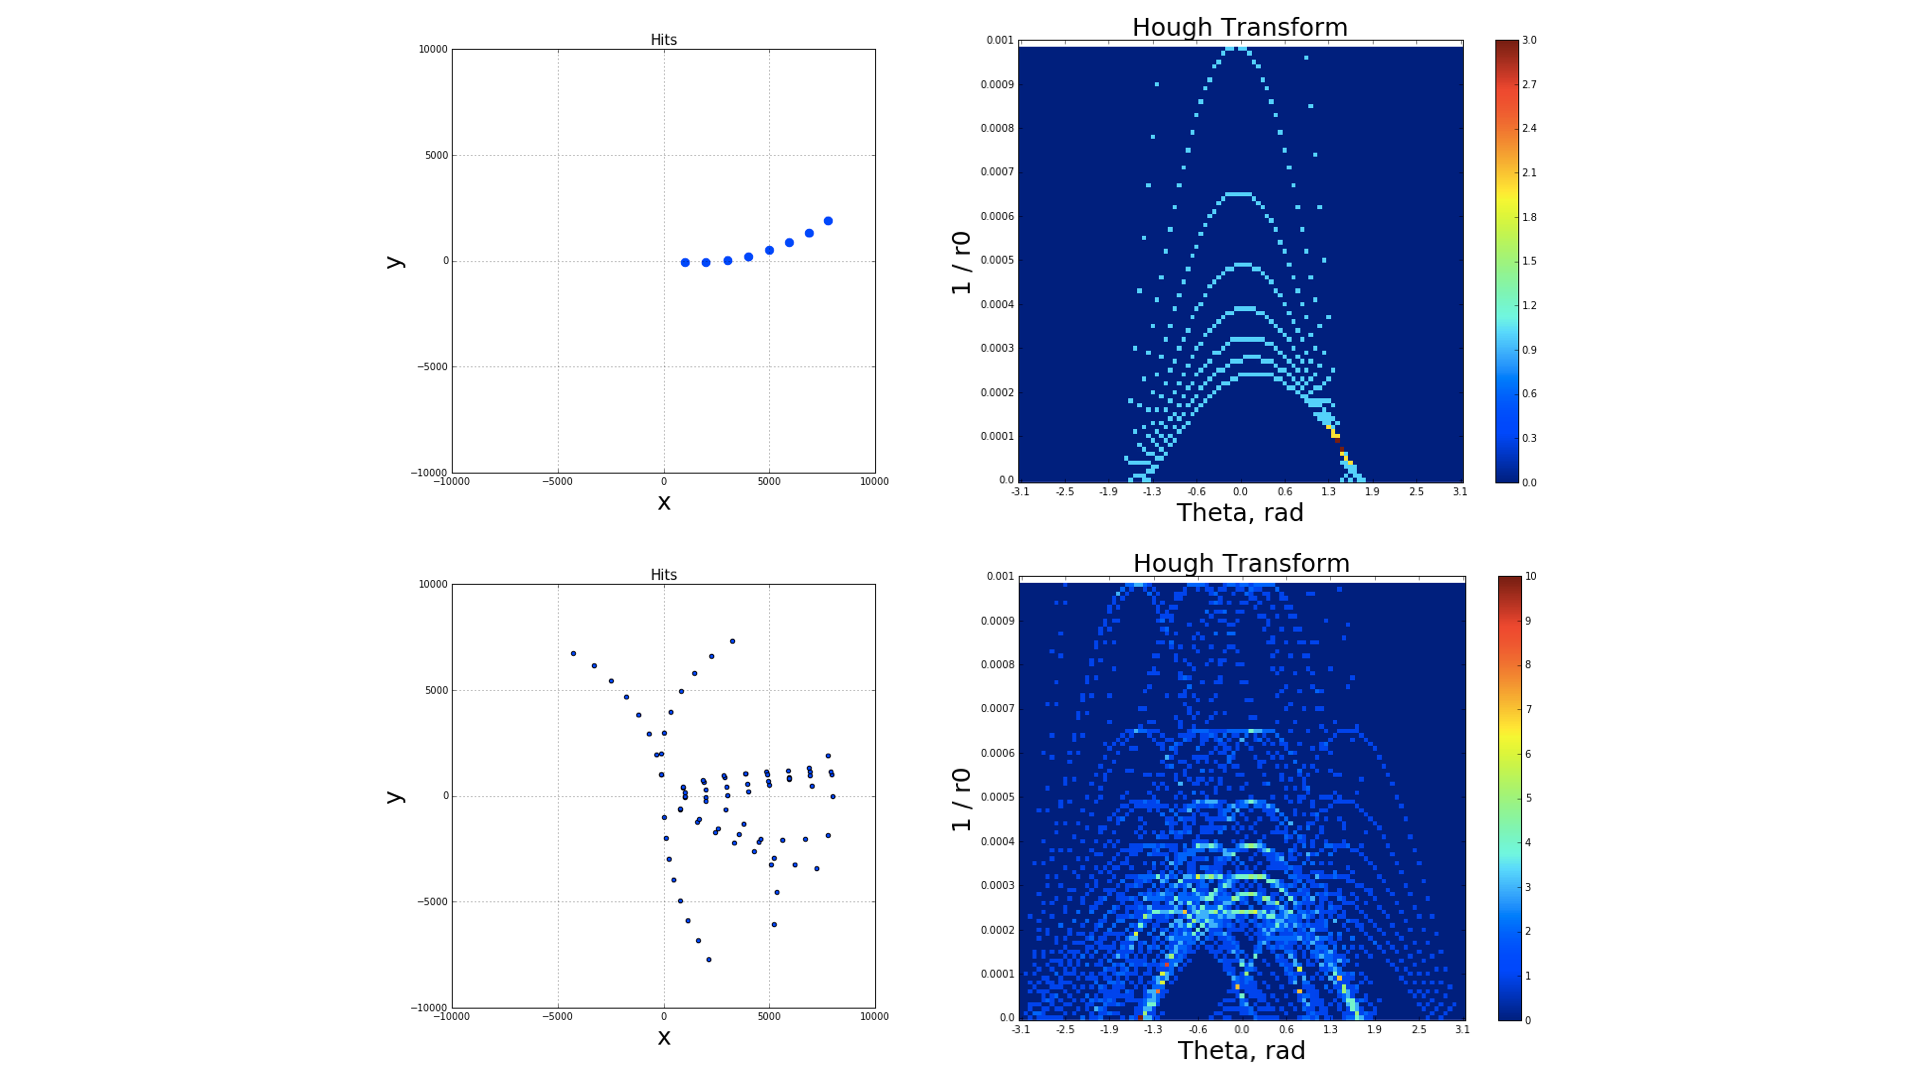

To assign only one track lable to a hit, only bins with the highest number of hits are selected. But there is one additional requirement for the bins: these bins must not share hits. Please, look the method script for details.

In [ ]:
def cartesian_to_cylindrical(x, y, z):
    
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    z = z
    
    return r, phi, z


def create_hough_matrix(hits):
    
    hough_matrix = hits[['hit_id', 'x', 'y', 'z']].copy()
    hough_matrix.columns = ['HitID', 'X', 'Y', 'Z']
    
    r, phi, z = cartesian_to_cylindrical(hough_matrix['X'].values, 
                                         hough_matrix['Y'].values, 
                                         hough_matrix['Z'].values)

    hough_matrix['R'] = r
    hough_matrix['Phi'] = phi
    
    return hough_matrix


def add_theta(hough_matrix, theta):
    hough_matrix['Theta'] = theta
    return hough_matrix

def add_r0_inv(hough_matrix):
    hough_matrix['R0Inv'] = (2. * np.cos(hough_matrix['Phi'] - hough_matrix['Theta']) / hough_matrix['R']).values
    return hough_matrix

def add_gamma(hough_matrix):
    hough_matrix['Gamma'] = hough_matrix['Z']/hough_matrix['R']
    return hough_matrix


def digitize_column(hough_matrix, col, N, min_val=None, max_val=None):
    
    x = hough_matrix[col].values
    if min_val is not None and max_val is not None:
        bins = np.linspace(min_val, max_val, N)
    else:
        bins = np.linspace(x.min(), x.max(), N)
    bin_ids = np.digitize(x, bins)
    hough_matrix[col+'Digi'] = bin_ids
    
    return hough_matrix


def combine_digi(hough_matrix, columns):
    
    hough_matrix['ComboDigi'] = np.zeros(len(hough_matrix))
    
    for i_col, acol in enumerate(columns):
        digi = hough_matrix[acol]
        hough_matrix['ComboDigi'] += digi * 10**(i_col * 5)
    
    return hough_matrix


def count_combo_digi(hough_matrix):
    
    unique, indeces, counts = np.unique(hough_matrix['ComboDigi'].values, 
                                     return_counts=True, return_inverse=True)
    hough_matrix['ComboDigiCounts'] = counts[indeces]
    
    return hough_matrix

def out_of_border_counters_to_zero(hough_matrix, col, N):
    hough_matrix['ComboDigiCounts'] *= (hough_matrix[col].values != 0) * (hough_matrix[col].values != N)
    return hough_matrix

def one_slice(hough_matrix, theta, N_bins_r0inv, N_bins_gamma, min_hits):
        
    tracks = []
    
    hough_matrix = add_theta(hough_matrix, theta)
    hough_matrix = add_r0_inv(hough_matrix)
    hough_matrix = add_gamma(hough_matrix)

    hough_matrix = digitize_column(hough_matrix, 'R0Inv', N_bins_r0inv, -0.02, 0.02) # Tune it.
    hough_matrix = digitize_column(hough_matrix, 'Gamma', N_bins_gamma, -50, 50) # Tune it.

    hough_matrix = combine_digi(hough_matrix, ['R0InvDigi', 'GammaDigi'])
    hough_matrix = count_combo_digi(hough_matrix)

    hough_matrix = out_of_border_counters_to_zero(hough_matrix, 'R0InvDigi', N_bins_r0inv)
    hough_matrix = out_of_border_counters_to_zero(hough_matrix, 'GammaDigi', N_bins_gamma)
    
    counts = hough_matrix.ComboDigiCounts.values
    bins = hough_matrix.ComboDigi.values
    hit_ids = np.arange(len(hough_matrix))
    for abin in np.unique(bins[counts >= min_hits]):
        atrack = hit_ids[(bins == abin)]
        tracks.append(atrack)
        
    return tracks, hough_matrix




class Clusterer(object):
    
    def __init__(self, N_bins_r0inv, N_bins_gamma, N_theta, min_hits):
        
        self.N_bins_r0inv = N_bins_r0inv 
        self.N_bins_gamma = N_bins_gamma
        self.N_theta = N_theta
        self.min_hits = min_hits
    
    def predict(self, hits):
        
        tracks = []

        hough_matrix = create_hough_matrix(hits)
        for theta in np.linspace(-np.pi, np.pi, self.N_theta):
            slice_tracks, hough_matrix = one_slice(hough_matrix, theta, self.N_bins_r0inv, self.N_bins_gamma, self.min_hits)
            tracks += list(slice_tracks)

        labels = np.zeros(len(hits))
        used = np.zeros(len(hits))
        track_id = 0
        for atrack in tracks:
            u_track = atrack[used[atrack] == 0]
            if len(u_track) >= self.min_hits:
                labels[u_track] = track_id
                used[u_track] = 1
                track_id += 1
            
        return labels

In [ ]:
%%time
# Warning: it takes about 100s per one event.

model = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=9)
labels = model.predict(hits)

## Score

Compute the score for this event. The dummy submission output of create_one_event_submission  is created only to be the second parameter of the score_event function. It should not be confused with a well-behaved submission for the test set. .

In [ ]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [ ]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [ ]:
print("Your score: ", score)

# Recognize tracks in all events of a dataset
In this example, the dataset is the whole training set.
This is a simple loop over the one-event actions: because of  there is no actual training.
This may take a very long time. To run on only a subset, use e.g.

     load_dataset(path_to_train, skip=1000, nevents=5)

It will skip the first 1000 events, and select the next 5 ones.

**Warning:** it takes about 100s per one event.

In [ ]:
dataset_submissions = []
dataset_scores = []

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=0, nevents=5):
        
    # Track pattern recognition
    model = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=9)
    labels = model.predict(hits)
        
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)
    
    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)
    
    print("Score for event %d: %.3f" % (event_id, score))
    
print('Mean score: %.3f' % (np.mean(dataset_scores)))

# Create a submission

Recognize tracks in all events of the test dataset and create a submission file.

**Warning:** it takes about 100s per one event.

In [ ]:
path_to_test = "../input/test"
test_dataset_submissions = []

create_submission = False # True for submission 

if create_submission:
    for event_id, hits, cells in load_dataset(path_to_test, parts=['hits', 'cells']):

        # Track pattern recognition
        model = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=9)
        labels = model.predict(hits)

        # Prepare submission for an event
        one_submission = create_one_event_submission(event_id, hits, labels)
        test_dataset_submissions.append(one_submission)
        
        print('Event ID: ', event_id)

    # Create submission file
    submission = pd.concat(test_dataset_submissions, axis=0)
    submission.to_csv('submission.csv.gz', index=False, compression='gzip')